In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [19]:
df = pd.read_csv("data/StudentsPerformance.csv", sep=",")
df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [20]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [21]:
df.describe()


,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [22]:
# Pass if math score >= 60
df['performance'] = (df['math score'] >= 60).astype(int)

df[['math score', 'performance']].head()


,math score,performance
0,72,1
1,69,1
2,90,1
3,47,0
4,76,1


In [23]:
categorical_cols = df.select_dtypes(include='object').columns

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,performance
0,0,1,1,1,1,72,72,74,1
1,0,2,4,1,0,69,90,88,1
2,0,1,3,1,1,90,95,93,1
3,1,0,0,0,1,47,57,44,0
4,1,2,4,1,1,76,78,75,1


In [24]:
X = df.drop('performance', axis=1)
y = df['performance']


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [27]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Results
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.98      1.00      0.99       135

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



In [28]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))


Random Forest Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00       135

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [29]:
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42
)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Results")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00       135

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [30]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_gb)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_gb)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_gb)
    ]
})

results


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.985,0.978261,1.0,0.989011
1,Random Forest,1.000,1.000000,1.0,1.000000
2,Gradient Boosting,1.000,1.000000,1.0,1.000000


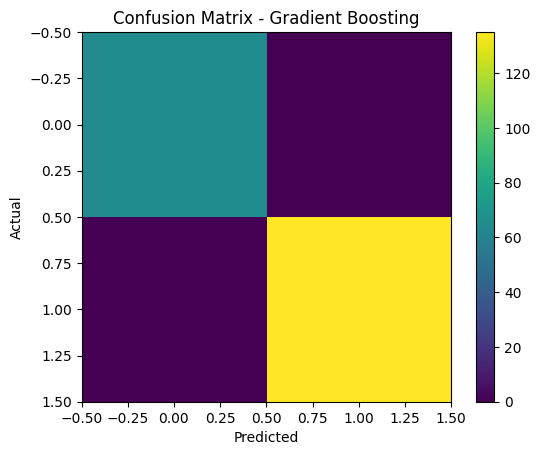

In [31]:
cm = confusion_matrix(y_test, y_pred_gb)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix - Gradient Boosting")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [32]:
importances = rf.feature_importances_
feature_names = X.columns

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
fi.head(10)


math score                     0.633532
writing score                  0.154369
reading score                  0.143970
gender                         0.023759
lunch                          0.015941
race/ethnicity                 0.013477
parental level of education    0.009190
test preparation course        0.005763
dtype: float64